# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Quadro K2000'
 => compute capability: (3, 0)
 => memory: 1893 / 1999 MB available


In [4]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int nbCols) {
    unsigned int iX = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int iY = blockIdx.y*blockDim.y + threadIdx.y;
    unsigned int position = iY*nbCols + iX;
    
    c[position] = a[position] + b[position];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

<bound method Figure.show of <Figure size 864x576 with 2 Axes>>

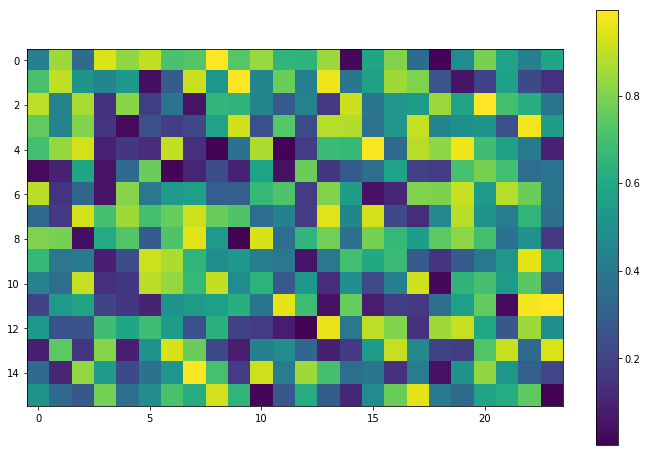

In [5]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show

In [6]:
print(a.shape)

(16, 24)


In [7]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [8]:
#a.shape = [rows, columns] => [y,x]
domain_size = (a.shape[1], a.shape[0])
block_size = (8,8,1)
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is" + str(domain_size))
print("Block size is" + str(block_size))
print("grid size is" + str(grid_size))

Domain size is(24, 16)
Block size is(8, 8, 1)
grid size is(3, 2, 1)


In [9]:
#Execute program on device
#Be careful of the number of columns, which is domain_size[0]
#in order to be sur to pass an int32, we use np.int32
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

In [10]:
#Copy data from device to host
c_g.get(c)

array([[0.60322267, 1.0468098 , 1.1983753 , 1.9262348 , 0.89835006,
        0.906222  , 1.4546161 , 1.6911205 , 1.978102  , 1.3054461 ,
        1.0412226 , 1.35692   , 1.0133168 , 1.2303996 , 0.10033523,
        1.2331028 , 1.5808566 , 1.2942475 , 0.5658936 , 0.8669513 ,
        0.88242453, 1.2309461 , 0.82934564, 0.69193554],
       [0.7168466 , 1.6120322 , 0.75725263, 1.157334  , 0.620676  ,
        0.48420516, 0.4940294 , 1.6156669 , 1.105315  , 1.4619782 ,
        0.62774295, 1.5831487 , 0.8725915 , 1.2806256 , 1.1019967 ,
        1.5444654 , 1.162895  , 1.7543331 , 0.26421344, 1.0163856 ,
        1.1796987 , 1.3012791 , 0.35339397, 0.40573174],
       [1.6354585 , 1.4026561 , 1.5605586 , 0.26916593, 1.7632315 ,
        0.3751415 , 0.72241926, 0.7698139 , 0.74775344, 0.7810175 ,
        1.2501473 , 0.3789937 , 1.1904    , 0.5639826 , 1.3499365 ,
        0.5003946 , 1.2212272 , 1.17519   , 1.2731848 , 0.99027365,
        1.9214172 , 0.792005  , 1.4393531 , 0.5552401 ],
       [1.631

In [11]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

('C   = ', array([[0.60322267, 1.0468098 , 1.1983753 , 1.9262348 , 0.89835006,
        0.906222  , 1.4546161 , 1.6911205 , 1.978102  , 1.3054461 ,
        1.0412226 , 1.35692   , 1.0133168 , 1.2303996 , 0.10033523,
        1.2331028 , 1.5808566 , 1.2942475 , 0.5658936 , 0.8669513 ,
        0.88242453, 1.2309461 , 0.82934564, 0.69193554],
       [0.7168466 , 1.6120322 , 0.75725263, 1.157334  , 0.620676  ,
        0.48420516, 0.4940294 , 1.6156669 , 1.105315  , 1.4619782 ,
        0.62774295, 1.5831487 , 0.8725915 , 1.2806256 , 1.1019967 ,
        1.5444654 , 1.162895  , 1.7543331 , 0.26421344, 1.0163856 ,
        1.1796987 , 1.3012791 , 0.35339397, 0.40573174],
       [1.6354585 , 1.4026561 , 1.5605586 , 0.26916593, 1.7632315 ,
        0.3751415 , 0.72241926, 0.7698139 , 0.74775344, 0.7810175 ,
        1.2501473 , 0.3789937 , 1.1904    , 0.5639826 , 1.3499365 ,
        0.5003946 , 1.2212272 , 1.17519   , 1.2731848 , 0.99027365,
        1.9214172 , 0.792005  , 1.4393531 , 0.5552401 ],
  

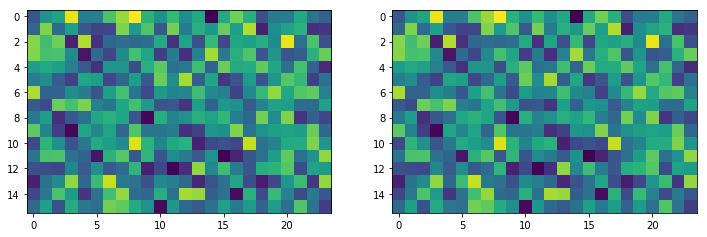

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)

In [8]:
print("shqhin")

shqhin
